In [2]:
import numpy as np
import os, math
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import theano.tensor as T
#from keras.initializations import *
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape, Permute, Lambda
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as Kr
#from keras.regularizers import l2, activity_l2
import keras, theano
from keras import backend as Kr
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline
import os, glob, scipy, pytesseract
d = '../data/letters'
files = glob.glob(d + '/*.png')
print len(files)
files = files[:100]



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (6021, 5105))
Using TensorFlow backend.


1000


## warning this exercise only works on this server  http://10.12.107.143:8881/notebooks/your initials/
## read dataset and genearte blurred images

In [3]:
ims = [scipy.misc.imread(path).astype(float) for path in files]

float64


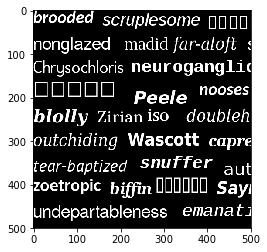

In [4]:
ims = ims[:100]
im = ims[0]
print im.dtype
plt.imshow(ims[0]/255)

## extract patches, construct X/y training set

In [5]:
N = 16 # N patches per images
W = H = 48 #size of pathes
IH, IW = im.shape[0:2]
pos = np.hstack((np.random.rand(N, 1) * (IH - H), np.random.rand(N, 1) * (IW - W)))
print pos.shape
def patch(im, (x,y)):
    x, y = int(x), int(y)
    return im[x:x+H,y:y+H,0:1]
patch(ims[0], (4,5))
patches = lambda im : [ patch(im, tuple(o)) for o in pos]

(16, 2)


In [6]:
sigma=1
blurs = [scipy.ndimage.filters.gaussian_filter(p, sigma=(sigma, sigma, 0)) for p in ims]

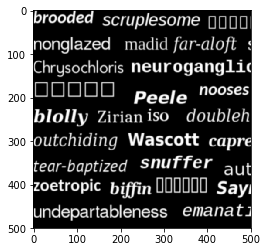

In [7]:
imr = blurs[0]
plt.imshow(imr/255)

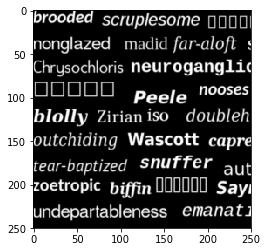

In [8]:
imrr =  scipy.misc.imresize(imr, (IH/2, IW/2), interp='nearest')
plt.imshow(imrr)

## define the network 

In [9]:
im = blurs[0]

batchSize = 32
FTYPE=float32
offset = 4
_or = lambda l : l[0] if len(l) == 1 else np.logical_or(l[0], _or(l[1:])) 

## Huber Loss
def huber(target, output):
    """
    Huber loss fct
    """
    delta = 0.1
    d1 = (target - output)
    d = d1
      
    #theano.printing.debugprint(d, print_type=True)
#    f = function([x], pd)
#    rrr = f(d)
    a = Kr.square(d) * 0.5
    b = delta * (Kr.abs(d) - delta / 2.)
    l = Kr.switch(Kr.abs(d) <= delta, a, b)
    if options.debug_mode == 'yes' :
        pd = (tprinter(Kr.mean(l, axis=-1)) + Kr.mean(tprinter(output)) + Kr.mean(tprinter(l)) + Kr.mean(tprinter(d)) + Kr.mean(tprinter(output.shape)) + Kr.mean(tprinter(target.shape))) * 1.e-11
    else :
        pd = 0.
    return Kr.mean(l, axis=-1) + pd #.mean(sum()


def fmask(bs, _W = W, _H = H) :
    s,t,u, v = np.mgrid[0:bs, 0:1, 0:_H, 0:_W]
    #s,t,u, v = np.mgrid[0:2, 0:1, 0:H, 0:W]
    # to compute error only within  the interior region of the patch, excluding the surrounding strip (because the filtering is noisy) 
    mask = np.where(_or((u < offset, u >= _H - offset, v < offset, v >= _W - offset)), 0.00001, 1.).astype(FTYPE)
    #EKOX(mask)
    return mask
    
mask =  theano.shared(fmask(batchSize))

In [10]:
model = Sequential()
def I(n, FW, FH, nchin) :
    __W = np.zeros((n, nchin, FH, FW))
    __W[:,:, FH/2,FW/2] = 1./nchin
    __Z = np.zeros(n)
    __W = __W + np.random.rand(n, nchin, FH, FW)/100
    return (__W, __Z)
FS1 = 3
NN = 32

inputs = Input((None, None, 1))
x = Convolution2D(NN, FS1, FS1, border_mode='same')(inputs)
x = LeakyReLU(alpha=0.1)(x) #Activation('sigmoid'))
x = Convolution2D(NN, FS1, FS1, border_mode='same')(x)
x = LeakyReLU(alpha=0.1)(x) #Activation('sigmoid'))
#model.add(Convolution2D(NN, FS1, FS1, border_mode='same'))
#model.add(LeakyReLU(alpha=0.1)) #Activation('sigmoid'))
x = Convolution2D(1, FS1, FS1, border_mode='same',
                        activation='linear')(x)
model = Model(inputs=inputs, output=x)
#model.add(Lambda(lambda x : x * mask))
opt = SGD(lr=0.001)
#opt = Adam()
model.compile(loss='mean_squared_error', optimizer=opt)

/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), padding="same", activation="linear")`
/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [11]:
X = np.asarray([x for im in blurs for x in patches(im)]).astype(float32)
y = np.asarray([x for im in ims for x in patches(im)]).astype(float32)
print X.shape
#X = X.transpose(0,3,2,1)/255
#y = y.transpose(0,3,2,1)/255
X = X/255
y = y/255
print X.shape, y.shape
print X.dtype

(1600, 48, 48, 1)
(1600, 48, 48, 1) (1600, 48, 48, 1)
float32


## train/val split

False False


(array([ 2129.,     4.,     4.,     4.,     3.,     3.,     4.,     5.,
           11.,   137.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

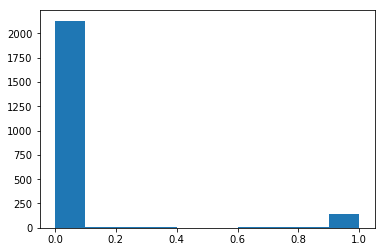

In [12]:
S = X.shape[0]/4 
print np.isnan(X).any(), np.isnan(y).any()
X_val, X_train = X[:S,:,:,:], X[S:,:,:,:] 
y_val, y_train = y[:S,:,:,:], y[S:,:,:,:]
plt.hist(y_train[0,:,:,:].flatten())

(1200, 48, 48, 1) (1200, 48, 48, 1)
(400, 48, 48, 1) (400, 48, 48, 1)


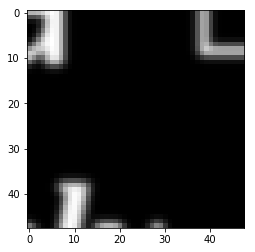

In [13]:
plt.imshow(X_train[0,:,:,0], cmap='gray')
print X_train.shape, y_train.shape
print X_val.shape, y_val.shape

## Train

In [ ]:
h = model.fit(X_train,
              y_train,
              batch_size=batchSize, nb_epoch=40, verbose=2,
              shuffle=True,
              validation_data = (X_val, y_val))

/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


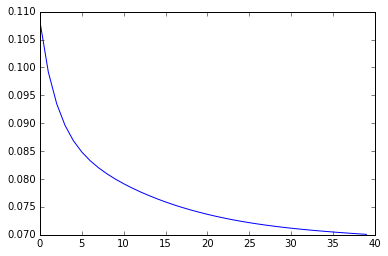

In [255]:
plt.plot(h.history['loss'])

## Checking result

(500, 500, 3)
(1, 1, 500, 500)
(1, 1, 500, 500)
(400, 1, 48, 48)
(500, 500, 3)


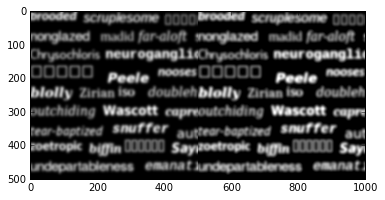

In [256]:
im = blurs[0]
print im.shape
imp = np.asarray([[im[:,:,0]]])/255
print imp.shape
pred = model.predict(X_val[0:1,:,:,:])

print np.asarray(imp).shape
pred = model.predict(np.asarray(imp))
pred = np.minimum(np.maximum(pred[0,0,:,:], 0), 1)
pred.shape

imshow(pred, cmap='gray')
print X_val.shape
print im.shape
#imshow(X_val[0,0,:,:], cmap='gray')
imshow(np.hstack((im[:,:,0]/255, pred)),  cmap='gray')

## test with OCR

In [257]:
import pytesseract
sys.path.append('..')
import pilutil

(409, 934, 3)


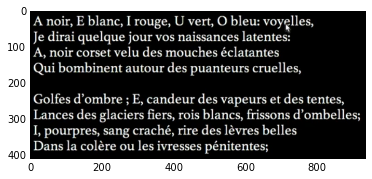

In [258]:
vy = 255. - scipy.misc.imread('../data/voyelles2.png').astype(float)
vy = vy[:,:,0:3]
vy = scipy.misc.imresize(vy, 150)
print vy.shape
plt.imshow(vy)

## reference text in the image

In [259]:
t0 = ' '.join(open('../data/voyelles.txt', "r").readlines()); t0

"A noir, E blanc, I rouge, U vert, O bleu : voyelles,\n Je dirai quelque jour vos naissances latentes :\n A, noir corset velu des mouches eclatantes\n Qui bombinent autour des puanteurs cruelles,\n \n Golfes d'ombre ; E, candeur des vapeurs et des tentes,\n Lances des glaciers fiers, rois blancs, frissons d'ombelles ;\n I, pourpres, sang crache, rire des levres belles\n Dans la colere ou les ivresses penitentes ;\n"

## The ocr works well

In [260]:
vim = pilutil.array2PIL(vy.astype(np.uint8), tuple(vy.shape[0:2][::-1]))
vim.save('vim.png')
t1 = pytesseract.image_to_string(vim) 
print t1

A noir, E blanc, I rouge, U vert, O bleu: voyglles,
Ie dirai quelque jour vos naissances latentes:

A, noir corset velu des mouches éclatantes

Qui bombinent autour des puanteurs cruelles,

Golfes d’ombre ; E, candeur des vapeurs et des tentes,
Lances des glaciers ﬁers, rois blancs, frissons d’ombelles;
I, pourpres, sang craché, rire des lévres belles

Dans la colére ou les ivresses pénitentes;


## But not at all on the blurred version...

Auk.lH-t.l~UmOhbuv-’ﬂs
bug-buh-mm
A‘mﬁbww
mun-madame.“

“lﬂslmhwahm
mthﬁH-nhd‘“
tum-ammuniti-
“bulb-uth


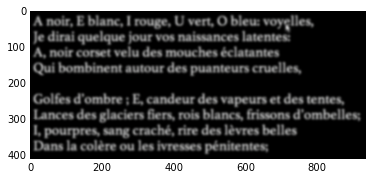

In [261]:
vyb = scipy.ndimage.filters.gaussian_filter(vy, sigma=3)
plt.imshow(vyb)
vim = pilutil.array2PIL(vyb.astype(np.uint8), tuple(vyb.shape[0:2][::-1]))
vim.save('vim.png')
t2 =  pytesseract.image_to_string(vim)
print t2

## let's deblur

(409, 934)


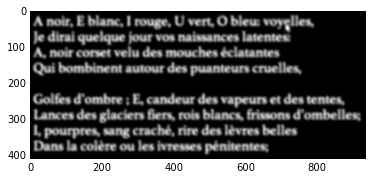

In [262]:
vybp = vyb.mean(axis=2)/255
print vybp.shape

pred = model.predict(np.asarray([[vybp]]))
plt.imshow(pred[0,0,:,:], cmap='gray')

(409, 934, 3)
tesser :  AmlhI~Um0hwyF
haphhuuh
Ada-It‘d.“th
minibus-alumni;

“(ﬁstmbwuh-ﬂ
mthuhhl-d-ln
Lmqmmhhw
hhﬁubmﬂﬁ-


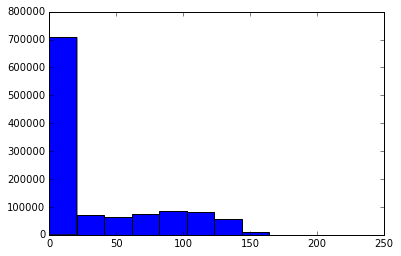

In [263]:
pred0 = np.minimum(np.maximum(pred[0,0,:,:], 0), 1)
pvy = np.dstack((pred0,pred0,pred0))*255
print pvy.shape
plt.hist(pvy.flatten())
vim = pilutil.array2PIL(pvy.astype(np.uint8), tuple(pvy.shape[0:2][::-1]))
vim.save('vim.png')
t3 =  pytesseract.image_to_string(vim) 
print 'tesser : ',t3

In [264]:
import editdistance
print [editdistance.eval(t0, t) for t in [t1,t2,t3]]

[34L, 371L, 372L]


##  improve the deblurrer  ! (beat 87 as an edit distance)